$f(x)=exp(-x_1^2 - 0.5(x_2 - 1)x_2)$

$\hat{f}(x)$ - linear combination of Chebyshev polynomials/their miltiplication

points from uniform distribution from $[-2, 2] \times [-2, 2]$

Рассмотрим задачу аппроксимации функции $f(x)=exp(-x_1^2 - 0.5(x_2 - 1)x_2)$ полиномами Чебышева - полиномами вида: 
$T_0(x) = 1$, $T_1(x)=x$, $T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$ на $[-2, 2]^2$.

В классическом подходе: $f(x) \approx \hat{f}(x) = \sum_{i=1}^{M}{\alpha_{i}P_i(x)}$, где $\alpha_i$ могут быть найдены с помощью метода наименьших квадратов, который будет уменьшать норму остатков в выбранных точках множества $[-2, 2]^2$: $\sum{(f(x_i) - \hat{f}(x_i))^2} \to \min$.

Рассмотрим другой подход, использующий информацию о градиентах функции f.
Будем решать следующую задачу: $A\alpha = F$, где $\alpha = (\alpha_1, \alpha_2, \dots, \alpha_M)^T$ - вектор весов, упомянутых выше. Назовем множество выбранных точек из $[-2, 2]^2$ множеством $G=\{(g_{1,1}, g_{1,2}), (g_{2,1}, g_{2,2}), \dots, (g_{k,1}, g_{k,2})\}$. Тогда $F$ - вектор размерности $3k$, состоящий из значений функции $F$ в точках множества $G$ и градиентов в этих же точках сначала по $x_1$, потом по $x_2$:

$$
F = \left(f(g_{1,1}, g_{1,2}), f(g_{2,1}, g_{2,2}), \dots, f(g_{k,1}, g_{k,2}), d_{x1}f(g_{1,1}, g_{1,2}),
d_{x1}f(g_{2,1}, g_{2,2}), \dots, d_{x1}f(g_{k,1}, g_{k,2}), d_{x2}f(g_{1,1}, g_{1,2}),
 \dots, d_{x2}f(g_{k,1}, g_{k,2})
\right).
$$

А матрица $A$ имеет вид:

$$
A=
\begin{bmatrix}
    P_{1}(g_{1,1}, g_{1,2}) & P_{2}(g_{1,1}, g_{1,2}) & \dots  & P_{M}(g_{1,1}, g_{1,2}) \\
    P_{1}(g_{2,1}, g_{2,2}) & P_{2}(g_{2,1}, g_{2,2}) & \dots  & P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    P_{1}(g_{k,1}, g_{k,2}) & P_{2}(g_{k,1}, g_{k,2}) & \dots  & P_{M}(g_{k,1}, g_{k,2}) \\
    d_{x_1}P_{1}(g_{1,1}, g_{1,2}) & d_{x_1}P_{2}(g_{1,1}, g_{1,2}) & \dots  & d_{x_1}P_{M}(g_{1,1}, g_{1,2}) \\
    d_{x_1}P_{1}(g_{2,1}, g_{2,2}) & d_{x_1}P_{2}(g_{2,1}, g_{2,2}) & \dots  & d_{x_1}P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    d_{x_1}P_{1}(g_{k,1}, g_{k,2}) & d_{x_1}P_{2}(g_{k,1}, g_{k,2}) & \dots  & d_{x_1}P_{M}(g_{k,1}, g_{k,2}) \\
    d_{x_2}P_{1}(g_{1,1}, g_{1,2}) & d_{x_2}P_{2}(g_{1,1}, g_{1,2}) & \dots  & d_{x_2}P_{M}(g_{1,1}, g_{1,2}) \\
    d_{x_2}P_{1}(g_{2,1}, g_{2,2}) & d_{x_2}P_{2}(g_{2,1}, g_{2,2}) & \dots  & d_{x_2}P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    d_{x_2}P_{1}(g_{k,1}, g_{k,2}) & d_{x_2}P_{2}(g_{k,1}, g_{k,2}) & \dots  & d_{x_2}P_{M}(g_{k,1}, g_{k,2}) \\
\end{bmatrix}
$$

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import accuracy_score
from copy import deepcopy
import torch
import torch.nn as nn
from torch.autograd import Variable, grad

In [2]:
class Net(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(Net, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out


net = Net(1, 1)

In [3]:
def learn(x, y, criterion, model, optimizer, verbose=False, epochs=500):
    inputs = Variable(torch.from_numpy(x))
    labels = Variable(torch.from_numpy(y))
    for epoch in range(epochs):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

    if verbose:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

In [4]:
import types
import functools
def copy_func(f):
    g = types.FunctionType(f.__code__, f.__globals__, name=f.__name__,
                           argdefs=f.__defaults__,
                           closure=f.__closure__)
    g = functools.update_wrapper(g, f)
    g.__kwdefaults__ = f.__kwdefaults__
    return g

def f(x1, x2):
    return torch.exp(-torch.pow(x1, 2) - 0.5 * (x2 - 1) * x2)

In [5]:
def Chebyshev_polynom(x, n):
    if n == 0:
        return torch.tensor(1., requires_grad=True)
    if n == 1:
        return x
    return 2 * x * Chebyshev_polynom(x, n - 1) - Chebyshev_polynom(x, n - 2)

In [6]:
def Fourier_polynom(x, n):
    if n == 0:
        return torch.tensor(1., requires_grad=True)
    if n % 2 == 0:
        return torch.sin(torch.tensor(n // 2 * x + 0.0, requires_grad=True))
    return torch.cos(torch.tensor((n + 1) // 2 * x + 0.0, requires_grad=True))

In [7]:
def Legendre_polynom(x, n):
    if n == 0:
        return torch.tensor(1., requires_grad=True)
    if n == 1:
        return x
    return (2*n-1)/n*x*Legendre_polynom(x, n-1) - (n-1)/n*Legendre_polynom(x, n-2)

In [8]:
def Standard_polynom(x, n):
    return x ** n

In [9]:
def polynom_builder(n, is_first_arg, func):
    t = copy_func(func)
    t.__defaults__ = (n,)
    if is_first_arg:
        return lambda x1, x2: t(x1)
    return lambda x1, x2: t(x2)

def polynom_combination_builder(n1, n2, func1, func2):
    t1 = copy_func(func1)
    t1.__defaults__ = (n1,)
    t2 = copy_func(func2)
    t2.__defaults__ = (n2,)
    return lambda x1, x2: t1(x1) * t2(x2)

In [10]:
def build_polynoms(polynom_type='Chebyshev'):
    if polynom_type == 'Chebyshev':
        polynom = Chebyshev_polynom
    elif polynom_type == 'Fourier':
        polynom = Fourier_polynom
    elif polynom_type == 'Legendre':
        polynom = Legendre_polynom
    elif polynom_type == 'Standard':
        polynom = Standard_polynom
    else:
        raise
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(polynom_builder(deg, True, polynom))
        t = P_polynoms[0]
        P_polynoms.append(polynom_builder(deg, False, polynom))
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(polynom_combination_builder(first_monom_deg, deg - first_monom_deg, polynom, polynom))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(polynom_combination_builder(deg - first_monom_deg, first_monom_deg, polynom, polynom))
    return P_polynoms

In [11]:
Chebyshev_polynoms = build_polynoms(polynom_type='Chebyshev')

Fourier_polynoms = build_polynoms(polynom_type='Fourier')

Legendre_polynoms = build_polynoms(polynom_type='Legendre')

Standard_polynoms = build_polynoms(polynom_type='Standard')

In [12]:
assert Standard_polynoms[0](99, 100) == 1
assert Standard_polynoms[1](99, 100) == 1
assert Standard_polynoms[2](99, 100) == 99
assert Standard_polynoms[3](99, 100) == 100
assert Standard_polynoms[4](99, 100) == 99*99

assert Legendre_polynoms[0](99, 100) == 1
assert Legendre_polynoms[1](99, 100) == 1
assert Legendre_polynoms[2](99, 100) == 99
assert Legendre_polynoms[3](99, 100) == 100
assert Legendre_polynoms[4](99, 100) == 1/2*(3*99**2-1)

assert Chebyshev_polynoms[0](99, 100) == 1
assert Chebyshev_polynoms[1](99, 100) == 1
assert Chebyshev_polynoms[2](99, 100) == 99
assert Chebyshev_polynoms[3](99, 100) == 100

assert Fourier_polynoms[0](1, 2) == 1
assert Fourier_polynoms[1](1, 2) == 1
# print(Fourier_polynoms[2](1, 2), torch.cos(torch.tensor(1., requires_grad=True)))
assert Fourier_polynoms[2](1, 2) == torch.cos(torch.tensor(1., requires_grad=True))
assert Fourier_polynoms[3](1, 2) == torch.cos(torch.tensor(2., requires_grad=True))
assert Fourier_polynoms[4](1, 2) == torch.sin(torch.tensor(1., requires_grad=True))
assert Fourier_polynoms[5](1, 2) == torch.sin(torch.tensor(2., requires_grad=True))

In [13]:
x1 = torch.tensor(0.1, requires_grad=True)
x2 = torch.tensor(0.2, requires_grad=True)
grad([Chebyshev_polynoms[0](x1, x2)], [x2], allow_unused=True)[0],

(None,)

In [46]:
def get_mean_l2_norm(size=50, p_count=5, verbose=False, epochs=10000, lr=1e-2, polynom_type='Chebyshev'):
    if polynom_type == 'Chebyshev':
        P_polynoms = Chebyshev_polynoms
    elif polynom_type == 'Fourier':
        P_polynoms = Fourier_polynoms
    elif polynom_type == 'Legendre':
        P_polynoms = Legendre_polynoms
    elif polynom_type == 'Standard':
        P_polynoms = Standard_polynoms
    else:
        raise
    SIZE = size
    P_COUNT = p_count
    
    mean_with_grad = []
    mean_no_grad = []
    for i in range(5):
        points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        tensors = [(torch.tensor(a[0], requires_grad=True), torch.tensor(a[1], requires_grad=True)) for a in points]
        F_with_grad = np.array(
            [f(p[0], p[1]) for p in tensors] + \
            [grad([f(p[0], p[1])], [p[0]], allow_unused=True)[0] for p in tensors] + \
            [grad([f(p[0], p[1])], [p[1]], allow_unused=True)[0] for p in tensors], dtype=np.float32).reshape(-1, 1)
        F_no_grad = np.array([f(p[0], p[1]) for p in tensors], dtype=np.float32).reshape(-1, 1)
        F_with_grad = np.nan_to_num(F_with_grad)  # If f is constant, grad=None
        A_with_grad = np.array(
            [[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in tensors] + \
            [[grad([P_polynoms[i](p[0], p[1])], [p[0]], allow_unused=True)[0] for i in range(P_COUNT)] for p in tensors] + \
            [[grad([P_polynoms[i](p[0], p[1])], [p[1]], allow_unused=True)[0] for i in range(P_COUNT)] for p in tensors], dtype=np.float32).reshape(-1, P_COUNT)
        A_no_grad = np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in tensors], dtype=np.float32).reshape(-1, P_COUNT)
        A_with_grad = np.nan_to_num(A_with_grad)  # If P is constant, grad=None
        r_with_grad = Net(P_COUNT, 1)
        r_no_grad = Net(P_COUNT, 1)
        
        criterion_with_grad = torch.nn.MSELoss() 
        optimizer_with_grad = torch.optim.Adam(r_with_grad.parameters(), lr=lr)
        
        criterion_no_grad = torch.nn.MSELoss() 
        optimizer_no_grad = torch.optim.Adam(r_no_grad.parameters(), lr=lr)
        
        learn(A_with_grad, F_with_grad, criterion_with_grad, r_with_grad, optimizer_with_grad, verbose=verbose, epochs=epochs)
        learn(A_no_grad, F_no_grad, criterion_no_grad, r_no_grad, optimizer_no_grad, verbose=verbose, epochs=epochs)
        def f_model_with_grad(x):
            if verbose:
                print('with grad weights', r_with_grad.linear.weight)
            return r_with_grad(x)

        def f_model_no_grad(x):
            if verbose:
                print('no grad weights', r_no_grad.linear.weight)
            return r_no_grad(x)
        
        test_points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        
        
        test_xs = test_points
        A_test = Variable(torch.from_numpy(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points], dtype=np.float32).reshape(-1, P_COUNT)))
#         print(np.arraf_model_with_grad(A_test).detach().numpy() - np.array([f(x) for x in test_xs]))
#         print(f_model_no_grad(A_test).detach().numpy() - np.array([f(x) for x in test_xs]))
        mean_with_grad.append(
            np.linalg.norm(np.array([f(p[0], p[1]).detach() for p in tensors]) - f_model_with_grad(A_test).detach().numpy().flatten()))
        mean_no_grad.append(
            np.linalg.norm(np.array([f(p[0], p[1]).detach() for p in tensors]) - f_model_no_grad(A_test).detach().numpy().flatten()))

#         mean_with_grad.append(
#             np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - np.array([f_model_with_grad(p[0], p[1]) for p in test_points])))
#         mean_no_grad.append(
#             np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - np.array([f_model_no_grad(p[0], p[1]) for p in test_points])))
        
#         print(mean_no_grad[-1], end=' ')
#         print(np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - r_no_grad.predict(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in test_points]))), end=' - ')
#         print(mean_with_grad[-1], end=' ')
#         print(np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - r_with_grad.predict(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in test_points]))))
    
        
    return np.mean(mean_with_grad), np.mean(mean_no_grad), np.var(mean_with_grad), np.var(mean_no_grad)

In [47]:
get_mean_l2_norm(size=50, p_count=30, verbose=True, polynom_type='Chebyshev', epochs=7000)

epoch 6999, loss 0.016473079100251198
epoch 6999, loss 0.00654720701277256
with grad weights Parameter containing:
tensor([[ 2.7038e-01,  2.6224e-01, -5.2320e-02,  2.1936e-01, -2.1682e-01,
         -8.2602e-02, -2.0290e-04, -1.4290e-02,  1.1208e-02, -4.3009e-02,
          1.8617e-02,  1.4067e-03,  8.9794e-03, -2.9926e-03,  7.6453e-04,
         -3.2675e-04, -2.5756e-03,  3.4057e-03,  5.0402e-05,  9.3574e-04,
         -5.8178e-04,  7.6235e-06, -6.4501e-04,  6.4134e-05,  1.0812e-03,
         -1.3165e-04, -3.0070e-05,  2.7914e-05,  1.7362e-04, -9.6326e-05]],
       requires_grad=True)
no grad weights Parameter containing:
tensor([[ 3.2424e-01,  1.9280e-01,  2.7418e-02,  2.4192e-01, -2.1155e-01,
         -7.1263e-02, -4.5697e-02, -2.2271e-02, -2.7433e-02, -6.0781e-02,
          1.7229e-02, -2.5372e-03,  1.3441e-02,  1.0858e-02,  7.8119e-03,
          1.0533e-03,  5.3170e-04,  2.9547e-03,  1.0418e-02,  9.2787e-04,
         -5.8372e-04,  1.6108e-04, -4.3459e-04, -5.1297e-04, -2.8053e-03,
    

(0.46581236, 0.34812814, 0.0050421227, 0.0061208797)

In [73]:
get_mean_l2_norm(size=200, p_count=15, verbose=True, polynom_type='Legendre')

epoch 9999, loss 0.03152097389101982
epoch 9999, loss 0.01143614761531353
with grad weights Parameter containing:
tensor([[ 3.8715e-01,  1.9370e-01, -6.4784e-03,  1.6194e-01, -1.9373e-01,
         -8.2757e-02,  2.9335e-03, -1.1825e-02,  9.1345e-04, -1.7499e-02,
          1.1155e-02,  3.1006e-03, -1.5768e-04,  3.5383e-04, -1.8331e-04]],
       requires_grad=True)
no grad weights Parameter containing:
tensor([[ 3.6351e-01,  2.2485e-01,  1.4955e-02,  1.9258e-01, -2.2506e-01,
         -9.0628e-02, -7.0250e-03, -1.4324e-02, -1.7720e-03, -2.9643e-02,
          1.5828e-02,  3.7012e-03,  1.6508e-03, -2.5062e-04,  7.5562e-04]],
       requires_grad=True)


(1.6341069, 1.5123844, 0.0, 0.0)

In [75]:
get_mean_l2_norm(size=200, p_count=15, verbose=True, polynom_type='Standard')

epoch 9999, loss 0.029198547825217247
epoch 9999, loss 0.011131303384900093
with grad weights Parameter containing:
tensor([[ 2.5871e-01,  4.7242e-01,  4.7407e-03,  2.0125e-01, -3.5787e-01,
         -1.3634e-01, -5.8275e-03, -2.8000e-02, -1.7875e-05, -3.2433e-02,
          5.3521e-02,  1.3148e-02,  7.4569e-04, -5.9817e-04,  1.4181e-03]],
       requires_grad=True)
no grad weights Parameter containing:
tensor([[ 0.4245,  0.3517,  0.0119,  0.2423, -0.4357, -0.1564, -0.0280, -0.0335,
          0.0030, -0.0534,  0.0740,  0.0175,  0.0020, -0.0010,  0.0075]],
       requires_grad=True)


(1.5895452, 1.4957368, 0.0, 0.0)

In [74]:
get_mean_l2_norm(size=200, p_count=50, verbose=True, polynom_type='Fourier')

/home/nuwanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/nuwanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


epoch 9999, loss 0.07458121329545975
epoch 9999, loss 5.319760930433404e-06
with grad weights Parameter containing:
tensor([[-2.5721e-02,  7.7223e-02,  3.2926e-01,  2.5851e-01,  7.5259e-03,
          5.6321e-02,  5.7060e-02, -4.6008e-02,  1.3944e-01, -1.3490e-02,
          1.9596e-03,  6.4247e-02,  1.4075e-01,  1.5192e-01,  3.6450e-02,
          3.0431e-02, -8.2881e-03, -2.6227e-03,  1.0946e-02,  4.8013e-02,
         -3.2013e-03, -1.2224e-02, -5.4349e-02,  1.6852e-02,  5.8751e-04,
         -1.8926e-04,  3.9172e-04, -6.1882e-03,  2.4608e-02,  4.5314e-03,
         -6.4130e-03,  1.4081e-02,  4.4813e-02,  7.2484e-04,  8.0246e-04,
          3.5526e-03,  1.2609e-02,  1.1727e-02, -4.3068e-04,  2.1873e-04,
          6.9002e-03,  1.4062e-03,  7.6234e-04,  2.8891e-05, -3.9337e-03,
         -1.6157e-03,  2.0468e-03,  4.9313e-03, -3.2398e-03, -1.3118e-03]],
       requires_grad=True)
no grad weights Parameter containing:
tensor([[ 7.9094e-02, -1.2988e-02,  3.2007e-01,  2.4031e-01,  6.4573e-03,
   

(0.01990535, 0.0267773, 0.0, 0.0)

In [48]:
def draw_stats_for_methods(methods, epochs):
    plt.figure(figsize=(20,10))
    sample_size = 50
    p_counts = np.arange(5, 40, 3)
    for m in methods:
        print(m, end=' ')
        mean_with_grad_res = []
        mean_no_grad_res = []
        var_with_grad_res = []
        var_no_grad_res = []
        for p_count in p_counts:
            print(p_count, end=',')
            mean_with_grad, mean_no_grad, var_with_grad, var_no_grad = get_mean_l2_norm(sample_size, p_count, epochs=epochs, polynom_type=m)
            mean_with_grad_res.append(mean_with_grad)
            mean_no_grad_res.append(mean_no_grad)
            var_with_grad_res.append(var_with_grad)
            var_no_grad_res.append(var_no_grad)

        plt.plot(p_counts, mean_with_grad_res, label='with grad %s' % m)
        plt.plot(p_counts, mean_no_grad_res, label='no grad %s' % m)
        print()
    plt.title('Mean norm, epochs=%d' % epochs)
    plt.xlabel('max polynom degree')
    plt.ylabel('mean l2-norm')
    plt.legend()
    plt.show()

Chebyshev 5,8,11,14,17,20,23,26,29,32,35,38,


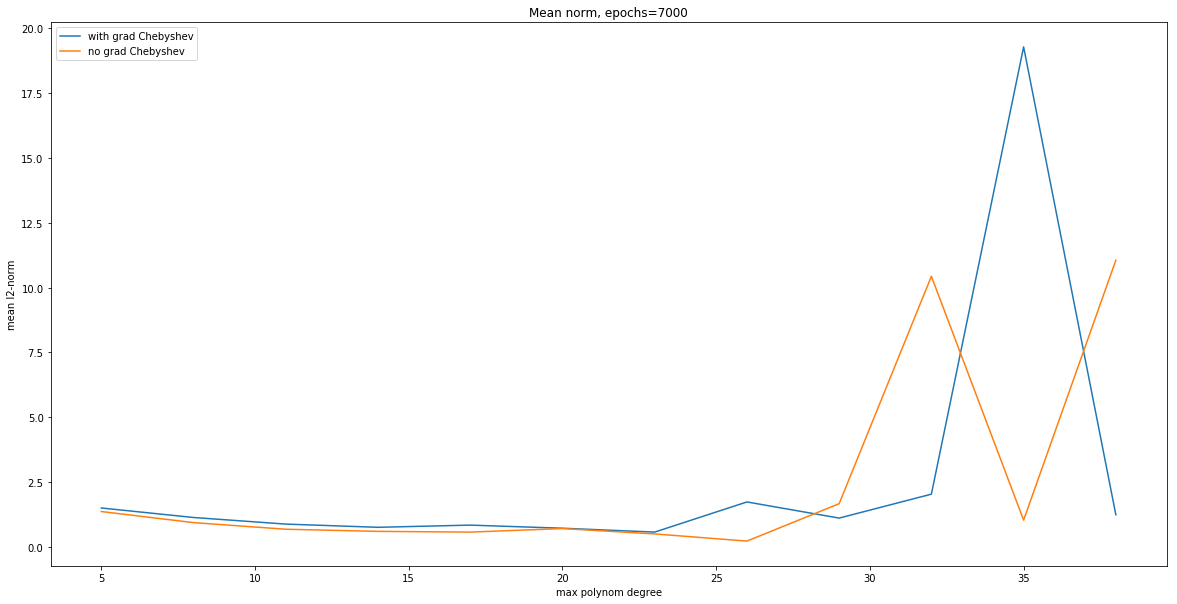

In [49]:
draw_stats_for_methods(['Chebyshev'], epochs=7000)

Legendre 5,8,11,14,17,20,23,26,29,32,35,38,


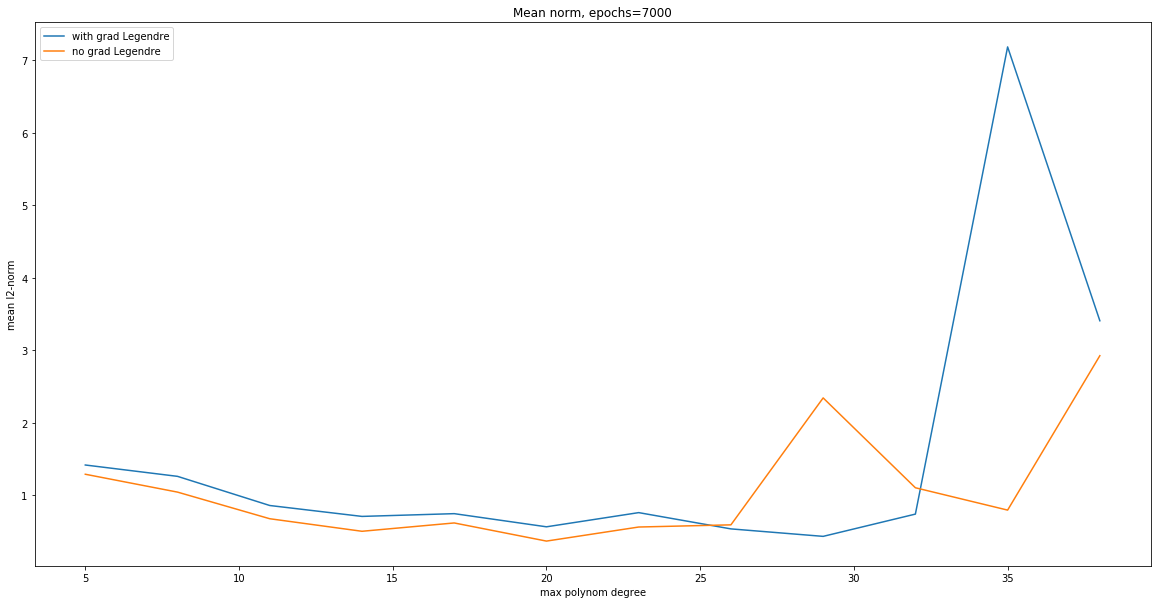

In [50]:
draw_stats_for_methods(['Legendre'], epochs=7000)

Fourier 5,

/home/nuwanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/nuwanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


8,11,14,17,20,23,26,29,32,35,38,


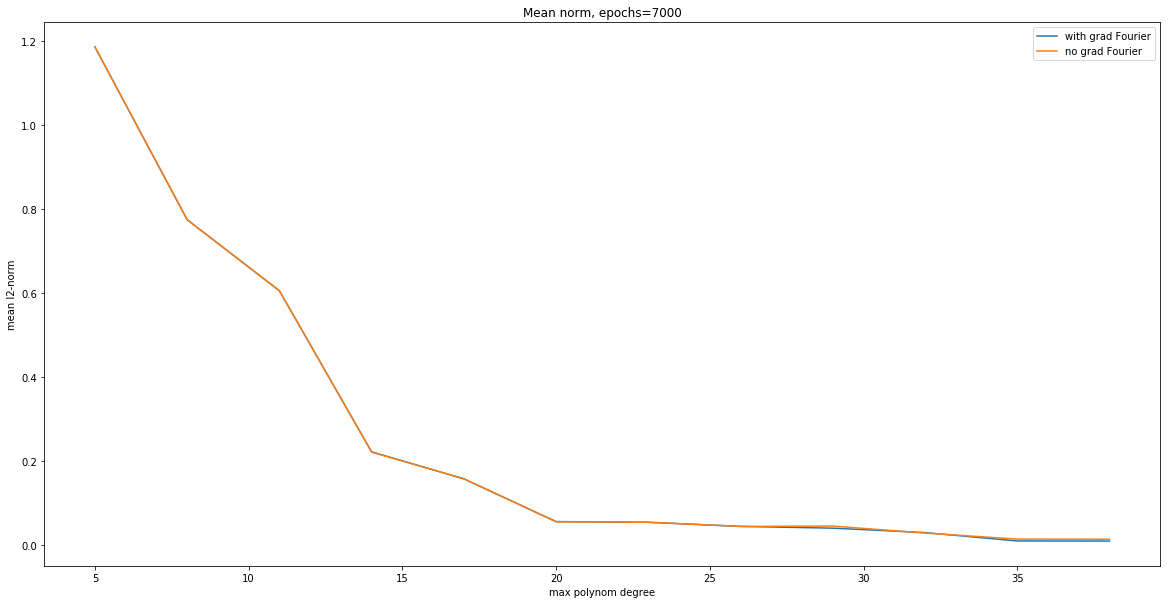

In [51]:
draw_stats_for_methods(['Fourier'], epochs=7000)

Standard 5,8,11,14,17,20,23,26,29,32,35,38,


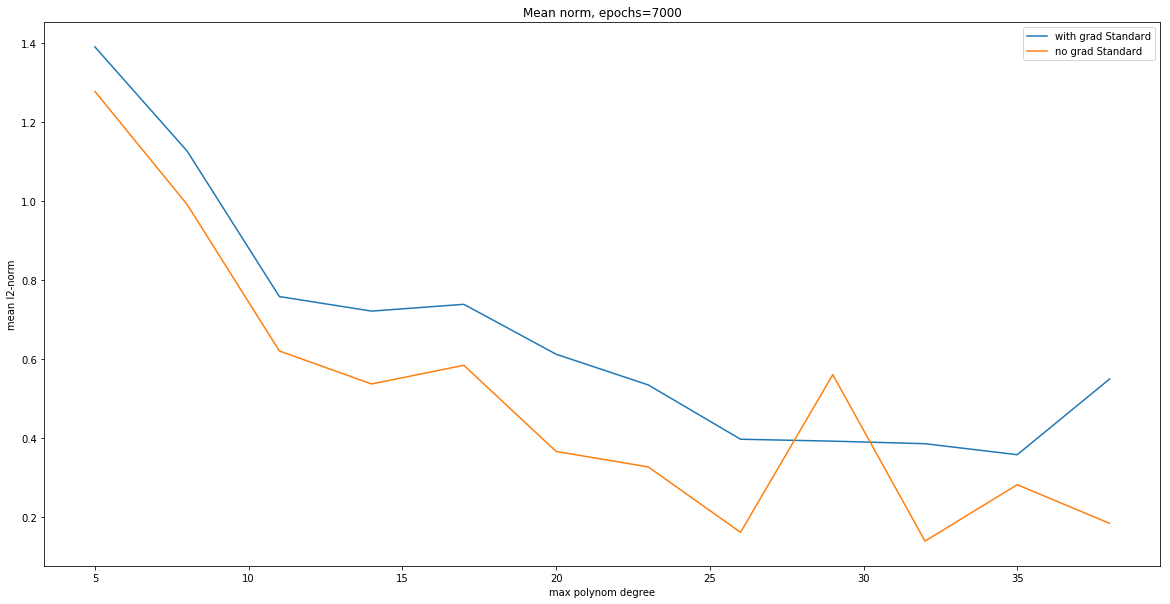

In [52]:
draw_stats_for_methods(['Standard'], epochs=7000)

Chebyshev 5,8,11,14,17,20,23,26,29,32,35,38,
Standard 5,8,11,14,17,20,23,26,29,32,35,38,
Fourier 5,

/home/nuwanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/nuwanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


8,11,14,17,20,23,26,29,32,35,38,
Legendre 5,8,11,14,17,20,23,26,29,32,35,38,


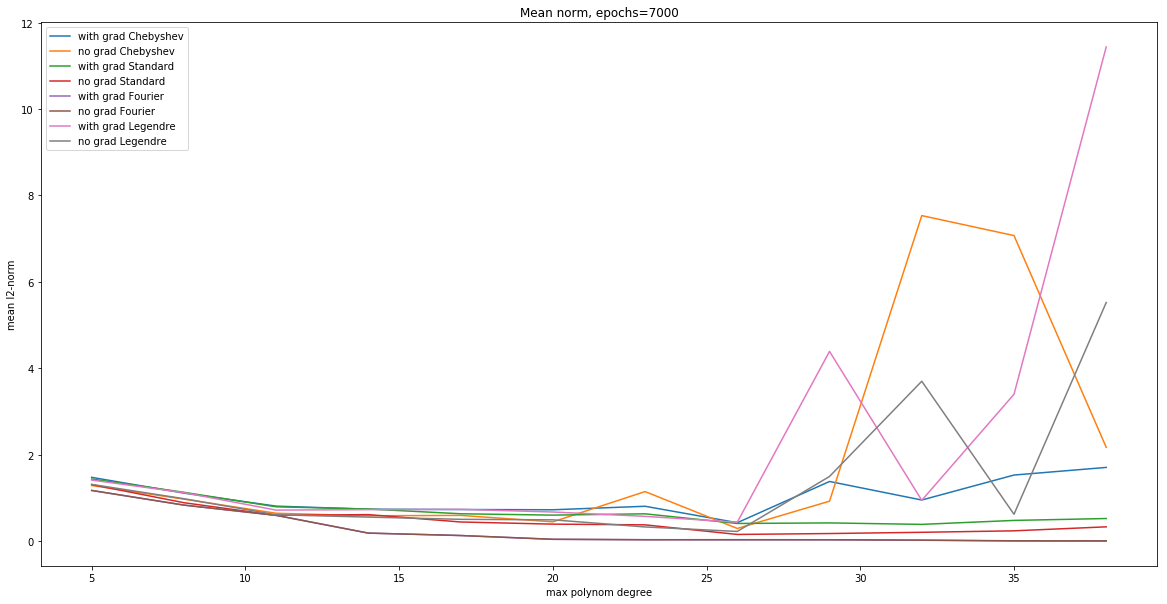

In [53]:
draw_stats_for_methods(['Chebyshev', 'Standard', 'Fourier', 'Legendre'], epochs=7000)